# Map one set of Pauli errors to another.

Requires numpy, matplotlib, qiskit, mitiq, qutip, and the PauliPER module.

In [1]:
#Helper libraries
from typing import List
import numpy as np
import numpy.typing as npt
import h5py

#make numpy matrices easier to read
np.set_printoptions(precision=3, linewidth=125, suppress=True)

# Qiskit
import qiskit
from qiskit.quantum_info import SuperOp
from qiskit import QuantumCircuit

from qutip import *
from qutip.qip.operations import hadamard_transform, cnot, rz

# Has to come after QuTiP or the QuTiP functions of the same name get priority
from mitiq.pec.channels import kraus_to_super

import matplotlib.ticker as tck
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from PauliPER.ns_utils_ import (_Trotter, find_optimal_representation_super,
                       z_Trotter_new, mk_circ)
from PauliPER.PauliNoise import PauliNoise, model_coeffs, mk_omega
from PauliPER.PauliExperiment import PauliExperiment, get_gates

Looking at the dynamical evolution of the transverse field Ising model:

\begin{equation}
H = J_z \sum_{i} \sigma^{z}_{i} \sigma^{z}_{i+1} + h_x \sum_{i} \sigma^x_{i}
\end{equation}

We want to have Pauli noise, and then modulate the noise to a different Pauli noise. Can start from a model with random Pauli noise in the form:

\begin{equation}
\Lambda = \prod_{k \in \mathcal{K}} w_k (I \otimes I) + (1 - w_k) (P_k \otimes P_k^T)
\end{equation}

where $w_k = (1/2)(1 - e^{-2\lambda_k})$, and then modulate it to Pauli noise modeled by a different set of constants $w'_k = (1/2)(1 - e^{-2\phi_k})$. The inverse map connecting the two models is:

\begin{equation}
\Lambda^{-1} = \gamma \prod_{k \in \mathcal{K}} \omega_k (I \otimes I) - (1 - \omega_k) (P_k \otimes P_k^T),
\end{equation}

where $\gamma = e^{\sum_{k | \lambda_k > \phi_k} 2(\lambda_k - \phi_k)}$ and

\begin{equation}
\omega_k = \begin{cases}(1/2)(1 - e^{-2(\lambda_k - \phi_k)}),&\text{ if }\lambda_k \geq \phi_k \\ 1~&\text{     else}\end{cases}\, .
\end{equation}

# Make error model

In [2]:
''' This is the order the operators are always in. '''

# Note that this locks in the number of qubits to 2. I haven't expanded the code
# to go to more qubits yet.

labels = ['XI', 'YI', 'ZI', 'IX', 'IY', 'IZ', 'XX', 'XY', 'XZ', 'YX', 'YY', 
          'YZ', 'ZX', 'ZY', 'ZZ']

In [3]:
'''
zz in model_coeffs sets it to generate a target error model that retains 
only IZ, ZI, and ZZ errors. The mapping should cancel everything else.
'''

# Seeds used: 132, 154, and 193
model_coeffs_lambda, model_coeffs_phi = model_coeffs(base1 = 1e-3, base2 = 5e-4, rnd_seed=132, zz=True, m=16)
print(f'Random deviations from a baseline: {model_coeffs_lambda}.\n')
print(f'Select model to approximate output: {model_coeffs_phi}.\n')

Random deviations from a baseline: [0.00124, 0.00076, 0.00175, 0.00151, 0.00139, 0.00088, 0.00059, 0.00059, 0.00051, 0.00043000000000000004, 0.00049, 0.00028, 0.00045, 0.00041, 0.0006000000000000001].

Select model to approximate output: [0, 0, 0.000109375, 0, 0, 5.5e-05, 0, 0, 0, 0, 0, 0, 0, 0, 3.7500000000000003e-05].



In [4]:
''' Instantiate a PauliNoise class with the model coefficients and the labels. '''
p_noise = PauliNoise(model_coeffs_lambda, labels)

In [5]:
''' Instantiate the target noise model coefficients. '''
p_noise.instantiate_target(model_coeffs_phi)

In [6]:
''' Create the inverse mapping. '''
p_noise.define_inverse()

In [7]:
''' One can print the associated probabilities if one wishes. '''
p_noise.inverse_omegas

[0.998761536329705,
 0.9992405773074605,
 0.9983620637088114,
 0.9984922778064312,
 0.998611930310831,
 0.9991756802508106,
 0.9994103479631211,
 0.9994103479631211,
 0.9994902600115885,
 0.9995701848470067,
 0.9995102400215865,
 0.9997200783853674,
 0.9995502024392637,
 0.9995901680540621,
 0.999437816287631]

In [8]:
''' These are the three overheads: for rx, rz, and cx respectively. '''
p_noise.gammas

(1.007307822755922, 1.007477820294151, 1.0236311431930996)

In [9]:
tot_gamma = p_noise.gammas[0]**2 * p_noise.gammas[1] * p_noise.gammas[2]**2

In [10]:
np.sqrt((tot_gamma**5)**2/1500)

0.03640732845053561

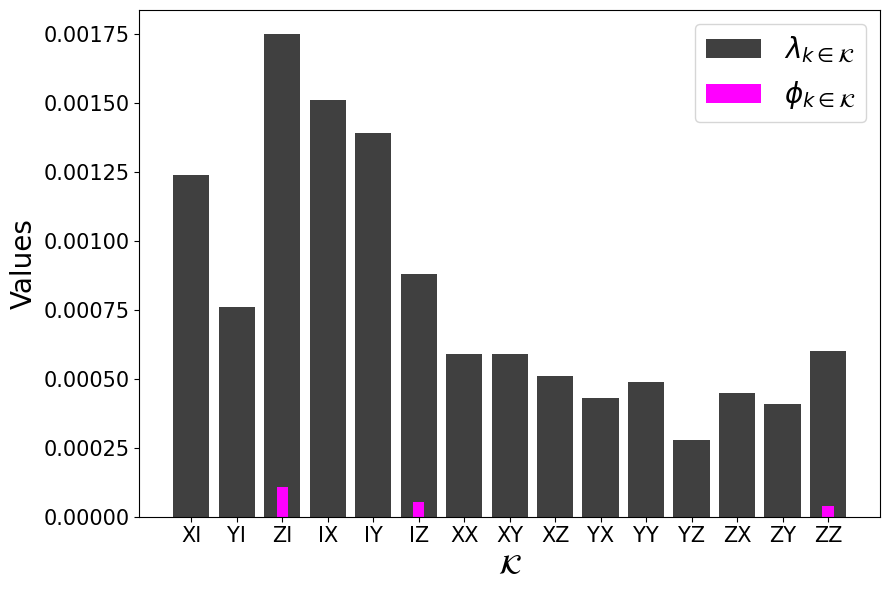

In [11]:
''' This displays the model coefficient bar graph. Can also title and save it to pdf. '''
p_noise.make_plot(ttl=None, font_size= 20, save_file='_model_coefficients')

## Now instantiate the error reduction algorithm.

In [12]:
'''
Generates a PauliExperiment class object. Give it the PauliNoise model created above,
the Trotter step size, the Jz coupling in the Hamiltonian, and the rx coupling.
'''
# p_experiment = []
# for n in range(15):
#     p_experiment.append(PauliExperiment(p_noise, 0.2, 1, 1))
p_experiment = PauliExperiment(p_noise, 0.2, 1, 1)

In [47]:
''' This runs a simulation. Give it the repetitions and the number of Trotter steps. '''
trotter_steps = 10
num_reps = 10000
# for n in range(len(p_experiment)):
#     p_experiment[n].run_experiment((n+1)*100, trotter_steps)

p_experiment.run_experiment(num_reps, trotter_steps)

In [48]:
''' Define the initial state. Here, I've set it to the all |+> state. '''
psi0x = tensor(hadamard_transform() * basis(2,0), hadamard_transform() * basis(2,0))
den0x = ket2dm(psi0x)
den0x_vec = operator_to_vector(den0x) # QuTiP uses the column stacking convention, like mitiq.

In [49]:
'''
The processed density matrices are saved individually, and then 
create_final_dm makes and saves the final density matrix after averaging.
'''
# for n in range(len(p_experiment)):
#     p_experiment[n].process_density_matrices(den0x_vec)
#     p_experiment[n].create_final_dm()
p_experiment.process_density_matrices(den0x_vec)
p_experiment.create_final_dm()

In [52]:
print(p_experiment.final_dm)
print(np.trace(p_experiment.final_dm))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.354+0.j    0.186+0.131j 0.187+0.13j  0.35 +0.j   ]
 [0.186-0.131j 0.151+0.j    0.15 +0.j    0.187-0.13j ]
 [0.187-0.13j  0.15 +0.j    0.151+0.j    0.186-0.131j]
 [0.35 +0.j    0.187+0.13j  0.186+0.131j 0.354+0.j   ]]
(1.0089437167387272+0j)


In [53]:
''' Can also perform the exact evolution for each error model within this class. '''
targ_wo_mit = p_experiment.evolve_target_without_mitigation(den0x_vec.copy(), trotter_steps)
targ_wo_mit

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.351+0.j    0.186+0.131j 0.186+0.131j 0.347+0.j   ]
 [0.186-0.131j 0.149+0.j    0.148+0.j    0.186-0.131j]
 [0.186-0.131j 0.148+0.j    0.149+0.j    0.186-0.131j]
 [0.347+0.j    0.186+0.131j 0.186+0.131j 0.351+0.j   ]]

In [54]:
init_wo_mit = p_experiment.evolve_initial_without_mitigation(den0x_vec.copy(), trotter_steps)
init_wo_mit

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.329+0.j    0.134+0.093j 0.138+0.086j 0.242+0.j   ]
 [0.134-0.093j 0.171+0.j    0.1  +0.j    0.138-0.086j]
 [0.138-0.086j 0.1  +0.j    0.171+0.j    0.134-0.093j]
 [0.242+0.j    0.138+0.086j 0.134+0.093j 0.329+0.j   ]]

Matrix distance: $\sqrt{\text{Tr}((A-B)(A-B)^\dagger)}$

In [55]:
''' Check the matrix distances of the density matrices. '''

rho_diff_ini = (init_wo_mit - targ_wo_mit)

print(f'Before mitigation: {np.sqrt((rho_diff_ini * rho_diff_ini.dag()).tr())}')

rho_diff_fin = (p_experiment.final_dm - targ_wo_mit)

print(f'After mitigation: {np.sqrt((rho_diff_fin * rho_diff_fin.dag()).tr())}')

Before mitigation: 0.24896924770834505
After mitigation: 0.007667642441760653


## Processing data for bar graphs.

In [56]:
comb_list_lambda = [(a, b) for a, b in zip(p_noise.lam_omegas, labels)]
comb_list_phi = [(a, b) for a, b in zip(p_noise.target_omegas, labels)]

In [57]:
outcome_lam = [(x, np.real((init_wo_mit * p_noise.model_gates[x]).tr())) for x in labels]
outcome_lam.insert(0, ('II', 1.0))

outcome_phi = [(x, np.real((targ_wo_mit * p_noise.model_gates[x]).tr())) for x in labels]
outcome_phi.insert(0, ('II', 1.0))

outcome_app = [(x, np.real((p_experiment.final_dm * p_noise.model_gates[x]).tr())) for x in labels]
outcome_app.insert(0, ('II', 1.0))

In [58]:
''' Make dictionaries of the expectation value outcomes. '''

outcome_lam_dict = {a: b for a, b in outcome_lam}
outcome_phi_dict = {a: b for a, b in outcome_phi}
outcome_app_dict = {a: b for a, b in outcome_app}

In [59]:
types = ['I', 'X', 'Y', 'Z']
x_lam = [1, 2, 3, 4]
y_lam = [1, 2, 3, 4]
z_lam = [outcome_lam_dict[a+b] for a in types for b in types]
z_phi = [outcome_phi_dict[a+b] for a in types for b in types]
z_app = [outcome_app_dict[a+b] for a in types for b in types]

In [60]:
''' Organize the data properly for plotting. '''
z_lam = np.zeros((4,4))
z_phi = np.zeros((4,4))
z_app = np.zeros((4,4))
for n,a in enumerate(['I', 'X', 'Y', 'Z'][::-1]):
    for m,b in enumerate(['I', 'X', 'Y', 'Z']):
        z_lam[n,m] = outcome_lam_dict[a+b]
        z_phi[n,m] = outcome_phi_dict[a+b]
        z_app[n,m] = outcome_app_dict[a+b]

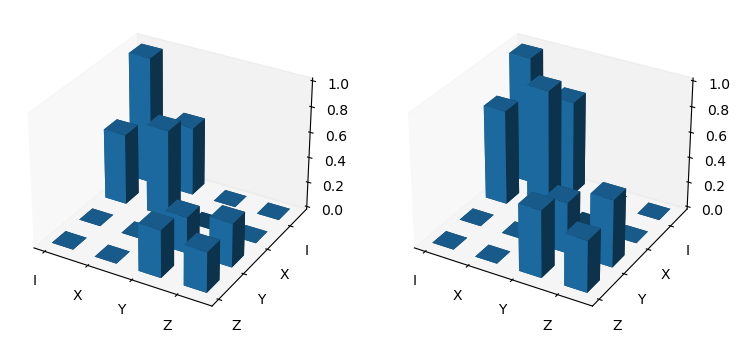

In [64]:
# set up the figure and axes
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.grid(False)
ax2.grid(False)

_x = [0, 1, 2, 3]
_y = [0, 1, 2, 3]
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

topl = np.abs(z_lam).flatten()
topp = np.abs(z_phi).flatten()
bottoml = np.zeros_like(topl)
bottomp = np.zeros_like(topp)
width = depth = 0.5

ax1.bar3d(x, y, bottoml, width, depth, topl, shade=True)
# ax1.set_title(r'$|Tr\rho_{\Lambda_{\lambda_k}}\cdot|$', fontsize=18)
majors = [0, 1, 2, 3]
ax1.xaxis.set_major_locator(tck.FixedLocator(majors))
ax1.yaxis.set_major_locator(tck.FixedLocator(majors))
ax1.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax1.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

ax2.bar3d(x, y, bottomp, width, depth, topp, shade=True)
# ax2.set_title(r'$|Tr\rho_{\Lambda_{\phi_k}}\cdot|$', fontsize=18)
ax2.xaxis.set_major_locator(tck.FixedLocator(majors))
ax2.yaxis.set_major_locator(tck.FixedLocator(majors))
ax2.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax2.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

plt.show()

In [65]:
with PdfPages(r'../../../writeup/_lam_v_target_exp_vals.pdf') as export_pdf:
    export_pdf.savefig(fig)

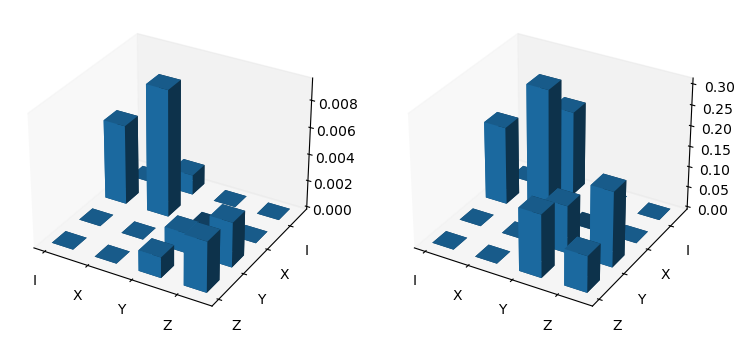

In [62]:
# set up the figure and axes
fig = plt.figure(figsize=(9, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.grid(False)
ax2.grid(False)

_x = [0, 1, 2, 3]
_y = [0, 1, 2, 3]
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

topl = np.abs(z_app - z_phi).flatten()
topp = np.abs(z_lam - z_phi).flatten()
bottoml = np.zeros_like(topl)
bottomp = np.zeros_like(topp)
width = depth = 0.5

ax1.bar3d(x, y, bottoml, width, depth, topl, shade=True)
# ax1.set_title(r'|$\rho_{\Lambda_{\lambda\to\phi}} - \rho_{\Lambda{\phi_k}}$|',
#              fontsize=18)
majors = [0, 1, 2, 3]
ax1.xaxis.set_major_locator(tck.FixedLocator(majors))
ax1.yaxis.set_major_locator(tck.FixedLocator(majors))
ax1.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax1.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

ax2.bar3d(x, y, bottomp, width, depth, topp, shade=True)
# ax2.set_title(r'|$\rho_{\Lambda_{\lambda_k}} - \rho_{\Lambda{\phi_k}}$|',
#              fontsize=18)
ax2.xaxis.set_major_locator(tck.FixedLocator(majors))
ax2.yaxis.set_major_locator(tck.FixedLocator(majors))
ax2.set_xticklabels(('I', 'X', 'Y', 'Z'))
ax2.set_yticklabels(('I', 'X', 'Y', 'Z')[::-1])

plt.show()

In [63]:
with PdfPages(r'../../../writeup/_per_v_target_exp_vals.pdf') as export_pdf:
    export_pdf.savefig(fig)

## Let's have a look at scaling with respect to number of reps

In [80]:
M = 50
rep_vector = [500*(m+1) for m in range(M)]

In [93]:
p_noise_list = []
p_noise_list_1 = []
p_noise_list_2 = []
for n in rep_vector:
    p_noise_list.append(PauliExperiment(p_noise, 0.2, 1, 1))
    p_noise_list_1.append(PauliExperiment(p_noise, 0.2, 1, 1))
    p_noise_list_2.append(PauliExperiment(p_noise, 0.2, 1, 1))

In [94]:
for m, n in enumerate(rep_vector):
    p_noise_list[m].run_experiment(n, trotter_steps)
    p_noise_list_1[m].run_experiment(n, trotter_steps)
    p_noise_list_2[m].run_experiment(n, trotter_steps)

In [95]:
for p, p1, p2 in zip(p_noise_list, p_noise_list_1, p_noise_list_2):
    p.process_density_matrices(den0x_vec)
    p1.process_density_matrices(den0x_vec)
    p2.process_density_matrices(den0x_vec)
    p.create_final_dm()
    p1.create_final_dm()
    p2.create_final_dm()

In [102]:
for p, p1, p2 in zip(p_noise_list, p_noise_list_1, p_noise_list_2):
    p.evolve_target_without_mitigation(den0x_vec)
    p1.evolve_target_without_mitigation(den0x_vec)
    p2.evolve_target_without_mitigation(den0x_vec)

In [103]:
no_mit_phi = p_noise_list[-1].evolve_target_without_mitigation(den0x_vec)
no_mit_phi_1 = p_noise_list_1[-1].evolve_target_without_mitigation(den0x_vec)
no_mit_phi_2 = p_noise_list_2[-1].evolve_target_without_mitigation(den0x_vec)

In [104]:
outcome_phi_chk = [(x, np.real((no_mit_phi * p_noise.model_gates[x]).tr())) for x in labels]
outcome_phi_chk.insert(0, ('II', 1.0))

outcome_app_list = []
outcome_app_list_1 = []
outcome_app_list_2 = []
for n in range(len(p_noise_list_1)):
    outcome_app_list.append([(x, np.real((p_noise_list[n].final_dm * p_noise.model_gates[x]).tr())) for x in labels])
    outcome_app_list[n].insert(0, ('II', 1.0))
    outcome_app_list_1.append([(x, np.real((p_noise_list_1[n].final_dm * p_noise.model_gates[x]).tr())) for x in labels])
    outcome_app_list_1[n].insert(0, ('II', 1.0))
    outcome_app_list_2.append([(x, np.real((p_noise_list_2[n].final_dm * p_noise.model_gates[x]).tr())) for x in labels])
    outcome_app_list_2[n].insert(0, ('II', 1.0))

In [106]:
summed_output = []
summed_output_1 = []
summed_output_2 = []
for rep, out, out1, out2 in zip(rep_vector, outcome_app_list, outcome_app_list_1, outcome_app_list_2):
    k = sum([np.abs(i[1] - j[1]) for i, j in zip(out, outcome_phi_chk)])
    k1 = sum([np.abs(i[1] - j[1]) for i, j in zip(out1, outcome_phi_chk)])
    k2 = sum([np.abs(i[1] - j[1]) for i, j in zip(out2, outcome_phi_chk)])
    summed_output.append((rep, k))
    summed_output_1.append((rep, k1))
    summed_output_2.append((rep, k2))

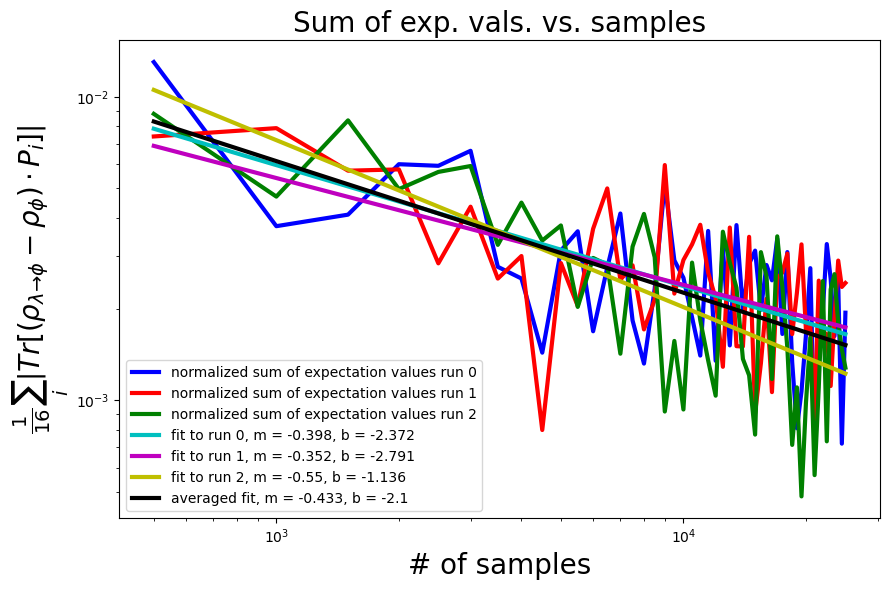

In [170]:
# bw = 'white'
bw = 'black'

fig, axes = plt.subplots(1,1, figsize=(9,6))

axes.plot([s[0] for s in summed_output], [s[1]/16 for s in summed_output],'-b',linewidth=3, label='normalized sum of expectation values run 0')
axes.plot([s[0] for s in summed_output_1], [s[1]/16 for s in summed_output_1],'-r',linewidth=3, label='normalized sum of expectation values run 1')
axes.plot([s[0] for s in summed_output_2], [s[1]/16 for s in summed_output_2],'-g',linewidth=3, label='normalized sum of expectation values run 2')

''' Best fit lines '''
fit_line_0 = np.polyfit([np.log(out[0]) for out in summed_output],[np.log(out[1]/16) for out in summed_output], deg = 1)
axes.plot([s[0] for s in summed_output], [np.exp(fit_line_0[0]*np.log(s[0]) + fit_line_0[1]) for s in summed_output], linewidth=3, color='c', 
            label=f'fit to run 0, m = {np.round(fit_line_0[0], 3)}, b = {np.round(fit_line_0[1], 3)}')

fit_line_1 = np.polyfit([np.log(out[0]) for out in summed_output_1],[np.log(out[1]/16) for out in summed_output_1], deg = 1)
axes.plot([s[0] for s in summed_output_1], [np.exp(fit_line_1[0]*np.log(s[0]) + fit_line_1[1]) for s in summed_output_1], linewidth=3, color='m', 
            label=f'fit to run 1, m = {np.round(fit_line_1[0], 3)}, b = {np.round(fit_line_1[1], 3)}')

fit_line_2 = np.polyfit([np.log(out[0]) for out in summed_output_2],[np.log(out[1]/16) for out in summed_output_2], deg = 1)
axes.plot([s[0] for s in summed_output_2], [np.exp(fit_line_2[0]*np.log(s[0]) + fit_line_2[1]) for s in summed_output_2], linewidth=3, color='y', 
            label=f'fit to run 2, m = {np.round(fit_line_2[0], 3)}, b = {np.round(fit_line_2[1], 3)}')

''' Averaged best fit line '''
emm = (fit_line_0[0] + fit_line_1[0] + fit_line_2[0])/3
bee = (fit_line_0[1] + fit_line_1[1] + fit_line_2[1])/3
axes.plot([s[0] for s in summed_output_2], [np.exp(emm*np.log(s[0]) + bee) for s in summed_output_2], linewidth=3, color='k', 
            label=f'averaged fit, m = {np.round(emm, 3)}, b = {np.round(bee, 3)}')
np.set_printoptions(precision=3)
axes.set_yscale('log')
axes.set_xscale('log')

axes.legend()

axes.set_title(r'Sum of exp. vals. vs. samples', fontsize=20, color=bw)

axes.set_xlabel(r'# of samples', fontsize=20, color=bw)
axes.set_ylabel(r'$\frac{1}{16}\sum_i |Tr[(\rho_{\lambda \to \phi} - \rho_{\phi})\cdot P_i]|$', fontsize=20, color=bw)
axes.tick_params(colors=bw, which='both')  # 'both' refers to minor and major axes

fig.tight_layout()
plt.show()

In [161]:
with PdfPages(r'../../../writeup/_sum_exp_vals_vs_samples_loglog.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [116]:
with h5py.File(r'../../../writeup/exp_vals_v_samples_figure/data.h5', 'w') as f:
    f.create_dataset('run_0', data=summed_output)
    f.create_dataset('run_1', data=summed_output_1)
    f.create_dataset('run_2', data=summed_output_2)

In [12]:
raw_output_data = []
fit_output_data = []

for i in range(13):
    for j in range(24):
        try:
            with h5py.File(f'./run_data/data4/data_run_{j}_rank_{i}.h5', 'r') as f:
                output = list(f['run_0'])
                raw_output_data.append(output)
                fit_line = np.polyfit([np.log(out[0]) for out in output], 
                                    [np.log(out[1]/16) for out in output], deg = 1)
                fit_output_data.append(fit_line)
        except:
            continue

for i in range(12):
    for j in range(24):
        try:
            with h5py.File(f'./run_data/data3/data_run_{j}_rank_{i}.h5', 'r') as f:
                output = list(f['run_0'])
                raw_output_data.append(output)
                fit_line = np.polyfit([np.log(out[0]) for out in output], 
                                    [np.log(out[1]/16) for out in output], deg = 1)
                fit_output_data.append(fit_line)
        except:
            continue

for i in range(6):
    for j in range(6):
        try:
            with h5py.File(f'./run_data/data2/data_run_{j}_rank_{i}.h5', 'r') as f:
                output = list(f['run_0'])
                raw_output_data.append(output)
                fit_line = np.polyfit([np.log(out[0]) for out in output], 
                                    [np.log(out[1]/16) for out in output], deg = 1)
                fit_output_data.append(fit_line)
        except:
            continue

for i in range(6):
    for j in range(6):
        try:
            with h5py.File(f'./run_data/data1/data_run_{j}_rank_{i}.h5', 'r') as f:
                output = list(f['run_0'])
                raw_output_data.append(output)
                fit_line = np.polyfit([np.log(out[0]) for out in output], 
                                    [np.log(out[1]/16) for out in output], deg = 1)
                fit_output_data.append(fit_line)
        except:
            continue

for i in range(6):
    for j in range(6):
        try:
            with h5py.File(f'./run_data/data0/data_run_{j}_rank_{i}.h5', 'r') as f:
                output = list(f['run_0'])
                raw_output_data.append(output)
                fit_line = np.polyfit([np.log(out[0]) for out in output], 
                                    [np.log(out[1]/16) for out in output], deg = 1)
                fit_output_data.append(fit_line)
        except:
            continue

In [13]:
''' Process fit data. '''
slopes = [data[0] for data in fit_output_data]
intercepts = [data[1] for data in fit_output_data]

slope_std = np.std(slopes)
intercept_std = np.std(intercepts)

slope_avg = np.average(slopes)
intercept_avg = np.average(intercepts)

slope_err = slope_std/np.sqrt(len(fit_output_data))
intercept_err = intercept_std/np.sqrt(len(fit_output_data))

slope_max_err = slope_avg + slope_err
slope_min_err = slope_avg - slope_err
intercept_max_err = intercept_avg + intercept_err
intercept_min_err = intercept_avg - intercept_err

print(slope_max_err, slope_min_err, intercept_max_err, intercept_min_err)
print(slope_err, intercept_err, slope_avg, intercept_avg)

-0.4688914692711462 -0.4747272890691041 -1.921927595033904 -1.9754122071373201
0.002917909898978971 0.026742306051708062 -0.47180937917012516 -1.948669901085612


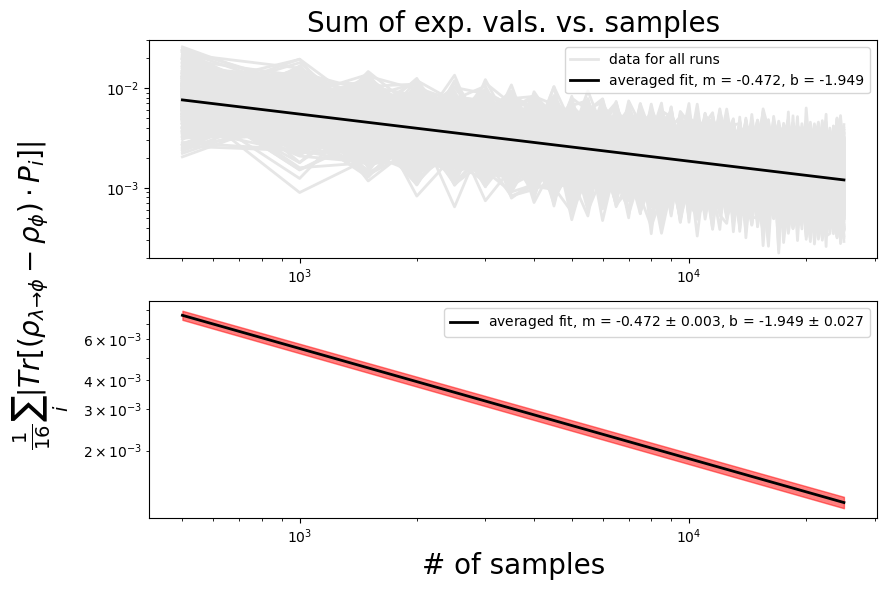

In [86]:
# bw = 'white'
bw = 'black'

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(9,6))

x = [s[0] for s in raw_output_data[0]]
y1 = np.exp(slope_max_err*np.log(x) + intercept_max_err)
y2 = np.exp(slope_min_err*np.log(x) + intercept_min_err)
y3 = np.exp(slope_avg*np.log(x) + intercept_avg)

for n, out in enumerate(raw_output_data):
    if n == 0:
        ax1.plot(x, [s[1]/16 for s in out], color='0.9', linewidth=2, label='data for all runs')
    else:
        ax1.plot(x, [s[1]/16 for s in out], color='0.9', linewidth=2)

ax1.plot(x, y3, linewidth=2, color='k', 
            label=f'averaged fit, m = {np.round(slope_avg, 3)}, b = {np.round(intercept_avg, 3)}')

ax2.fill_between(x, y1, y2, color='red', alpha=0.5)

ax2.plot(x, y3, linewidth=2, color='k', 
            label=f'averaged fit, m = {np.round(slope_avg, 3)} $\pm$ {np.round(slope_err, 3)}, b = {np.round(intercept_avg, 3)} $\pm$ {np.round(intercept_err, 3)}')

ax1.set_yscale('log')
ax1.set_xscale('log')

ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.set_ybound(3e-2, 2e-4)
# ax2.set_ybound(3e-2, 2e-4)


ax1.legend()
ax2.legend()

ax1.set_title(r'Sum of exp. vals. vs. samples', fontsize=20, color=bw)
ax2.set_xlabel(r'# of samples', fontsize=20, color=bw)
fig.supylabel(r'$\frac{1}{16}\sum_i |Tr[(\rho_{\lambda \to \phi} - \rho_{\phi})\cdot P_i]|$', fontsize=20, color=bw)

fig.tight_layout()
plt.show()

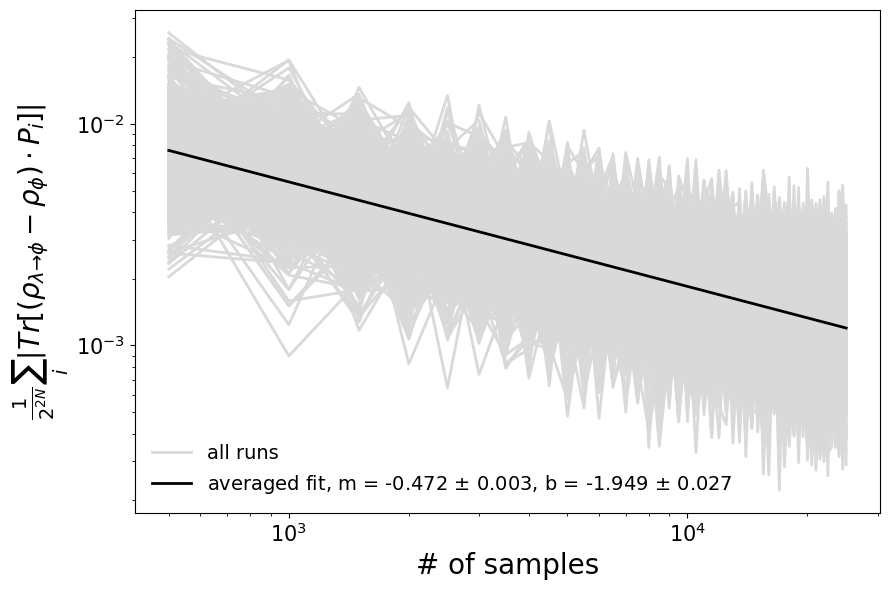

In [20]:
# bw = 'white'
bw = 'black'

fig, ax = plt.subplots(1,1, figsize=(9,6))

x = [s[0] for s in raw_output_data[0]]
y1 = np.exp(slope_max_err*np.log(x) + intercept_max_err)
y2 = np.exp(slope_min_err*np.log(x) + intercept_min_err)
y3 = np.exp(slope_avg*np.log(x) + intercept_avg)

for n, out in enumerate(raw_output_data):
    if n == 0:
        ax.plot(x, [s[1]/16 for s in out], color='0.85', linewidth=2, label='all runs')
    else:
        ax.plot(x, [s[1]/16 for s in out], color='0.85', linewidth=2)

ax.fill_between(x, y1, y2, color='red', alpha=0.5)

ax.plot(x, y3, linewidth=2, color='k', 
            label=f'averaged fit, m = {np.round(slope_avg, 3)} $\pm$ {np.round(slope_err, 3)}, b = {np.round(intercept_avg, 3)} $\pm$ {np.round(intercept_err, 3)}')

ax.set_yscale('log')
ax.set_xscale('log')

#ax.set_ybound(3e-2, 2e-4)

ax.legend(frameon=False, fontsize=14)

# ax.set_title(r'Sum of exp. vals. vs. samples', fontsize=20, color=bw)
ax.set_xlabel(r'# of samples', fontsize=20, color=bw)
ax.set_ylabel(r'$\frac{1}{2^{2N}}\sum_i |Tr[(\rho_{\lambda \to \phi} - \rho_{\phi})\cdot P_i]|$', fontsize=20, color=bw)
ax.tick_params(colors=bw, which='both', labelsize=15)

fig.tight_layout()
plt.show()

In [21]:
with PdfPages(r'../../../writeup/_sum_exp_vals_vs_samples_avg_w_err.pdf') as export_pdf:
    export_pdf.savefig(fig)

In [88]:
qiskit.__file__

'/opt/anaconda3/envs/pa_per_env/lib/python3.10/site-packages/qiskit/__init__.py'